In [1]:
!pip install evaluate
!pip install bert_score

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from evaluate import load
from seq2seq__utils import create_transformers_train_data, decode_with_transformer, train_transformer

C:\FINKI\VII_semestar\NLP\code\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
data = pd.read_csv('../../data/yelp/test_en_parallel.txt', sep='\t', header=None)
data = data[[0, 1]]
data.columns = ['NEG', 'POS']

print(f"Total pairs: {len(data)}")
data.head()

Total pairs: 1001


,NEG,POS
0,Style 1,Style 2
1,ever since joes has changed hands it's just go...,Ever since joes has changed hands it's gotten ...
2,there is definitely not enough room in that pa...,There is so much room in that part of the venue
3,so basically tasted watered down.,It didn't taste watered down at all.
4,she said she'd be back and disappeared for a f...,"She said she'd be back, and didn't disappear a..."


In [5]:
neg_sentences = data['NEG'].values
pos_sentences = data['POS'].values

X_train, X_temp, y_train, y_temp = train_test_split(
    neg_sentences, pos_sentences, test_size=0.2, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Train pairs: {len(X_train)}")
print(f"Validation pairs: {len(X_val)}")
print(f"Test pairs: {len(X_test)}")

Train pairs: 800
Validation pairs: 100
Test pairs: 101


In [27]:
model_name_t5 = "t5-small"

tokenizer_t5 = AutoTokenizer.from_pretrained(model_name_t5)

instruction = "make positive: "

train_inputs = [f"{instruction}{s}" for s in X_train]
val_inputs   = [f"{instruction}{s}" for s in X_val]
test_inputs  = [f"{instruction}{s}" for s in X_test]

In [29]:
def evaluate_seq2seq(model, tokenizer, inputs, references, device='cpu', max_samples=None):
    model = model.to(device)
    model.eval()

    preds, refs = [], []

    bleu = load('bleu')
    bertscore = load('bertscore')

    with torch.no_grad():
        for i, (src, tgt) in enumerate(zip(inputs, references)):
            if max_samples is not None and i >= max_samples:
                break

            pred = decode_with_transformer(src, tokenizer, model, device=device)
            preds.append(pred)
            refs.append(tgt)

    bleu_score = bleu.compute(predictions=preds, references=refs)['bleu']

    bert = bertscore.compute(
        predictions=preds,
        references=refs,
        model_type='microsoft/deberta-xlarge-mnli'
    )
    bert_f1 = float(np.mean(bert['f1']))

    return bleu_score, bert_f1, preds, refs

In [30]:
configs_t5_instruction = [
    {'name': 'higher_lr', 'lr': 0.001, 'epochs': 3, 'batch_size': 64},
    {'name': 'medium_lr', 'lr': 0.0005, 'epochs': 3, 'batch_size': 64},
    {'name': 'low_lr_more_epochs', 'lr': 0.00002, 'epochs': 5, 'batch_size': 64},
]

In [31]:
results_t5_instruction = []

for cfg in configs_t5_instruction:
    print(f"\nTraining T5 (instructional fine-tuning) with config: {cfg['name']}")

    model_t5 = AutoModelForSeq2SeqLM.from_pretrained(model_name_t5)

    train_set = create_transformers_train_data(train_inputs, y_train.tolist(), tokenizer_t5)

    data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer_t5, model=model_t5)
    train_loader = DataLoader(
        train_set,
        batch_size=cfg['batch_size'],
        shuffle=True,
        collate_fn=data_collator
    )

    optimizer = AdamW(model_t5.parameters(), lr=cfg['lr'])

    history = train_transformer(
        model_t5,
        train_loader,
        optimizer,
        epochs=cfg['epochs'],
        device=device
    )

    bleu, bert_f1, preds, refs = evaluate_seq2seq(
        model_t5,
        tokenizer_t5,
        test_inputs,
        y_test,
        device=device,
        max_samples=None
    )

    print(f"Config {cfg['name']} | BLEU: {bleu:.4f} | BERTScore-F1: {bert_f1:.4f}")

    results_t5_instruction.append({
        'config': cfg,
        'bleu': bleu,
        'bertscore_f1': bert_f1,
        'history': history
    })


Training T5 (instructional fine-tuning) with config: higher_lr


C:\FINKI\VII_semestar\NLP\code\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Epoch 1/3, Loss: 3.1990
Epoch 2/3, Loss: 2.5578
Epoch 3/3, Loss: 2.2652
Config higher_lr | BLEU: 0.2240 | BERTScore-F1: 0.7625

Training T5 (instructional fine-tuning) with config: medium_lr
Epoch 1/3, Loss: 3.3406
Epoch 2/3, Loss: 2.7395
Epoch 3/3, Loss: 2.5096
Config medium_lr | BLEU: 0.2205 | BERTScore-F1: 0.7526

Training T5 (instructional fine-tuning) with config: low_lr_more_epochs
Epoch 1/5, Loss: 4.3326
Epoch 2/5, Loss: 3.9865
Epoch 3/5, Loss: 3.8462
Epoch 4/5, Loss: 3.7277
Epoch 5/5, Loss: 3.6280
Config low_lr_more_epochs | BLEU: 0.0632 | BERTScore-F1: 0.4896


In [32]:
results_df = pd.DataFrame([
    {
        'Config': r['config']['name'],
        'Learning Rate': r['config']['lr'],
        'Epochs': r['config']['epochs'],
        'Batch Size': r['config']['batch_size'],
        'BLEU': f"{r['bleu']:.4f}",
        'BERTScore-F1': f"{r['bertscore_f1']:.4f}"
    }
    for r in results_t5_instruction
])

print("T5 (Instructional fine-tuning) – hyperparameter comparison:")
print(results_df.to_string(index=False))

T5 (Instructional fine-tuning) – hyperparameter comparison:
            Config  Learning Rate  Epochs  Batch Size   BLEU BERTScore-F1
         higher_lr        0.00100       3          64 0.2240       0.7625
         medium_lr        0.00050       3          64 0.2205       0.7526
low_lr_more_epochs        0.00002       5          64 0.0632       0.4896


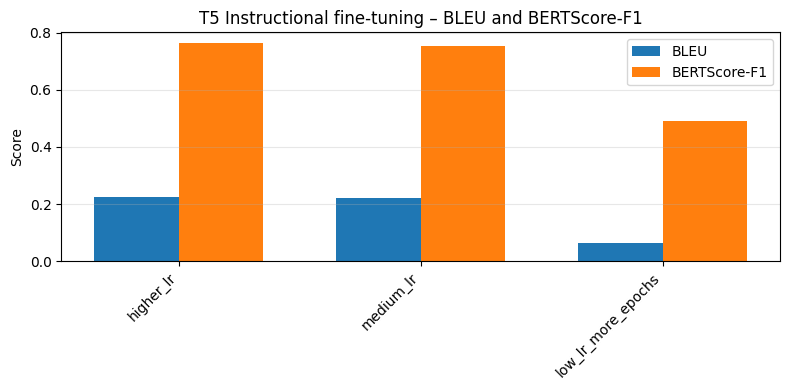

In [33]:
cfg_names = [r['config']['name'] for r in results_t5_instruction]
bleu_scores = [r['bleu'] for r in results_t5_instruction]
bert_f1s = [r['bertscore_f1'] for r in results_t5_instruction]

x = np.arange(len(cfg_names))
width = 0.35

plt.figure(figsize=(8,4))
plt.bar(x - width/2, bleu_scores, width, label='BLEU')
plt.bar(x + width/2, bert_f1s, width, label='BERTScore-F1')

plt.xticks(x, cfg_names, rotation=45, ha='right')
plt.ylabel('Score')
plt.title('T5 Instructional fine-tuning – BLEU and BERTScore-F1')
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
best_task2 = max(results_t5_instruction, key=lambda x: x['bertscore_f1'])
print("BEST Task 2 config:")
print(best_task2['config'])
print(f"BLEU: {best_task2['bleu']:.4f}")
print(f"BERTScore-F1: {best_task2['bertscore_f1']:.4f}")

BEST Task 2 config:
{'name': 'higher_lr', 'lr': 0.001, 'epochs': 3, 'batch_size': 64}
BLEU: 0.2240
BERTScore-F1: 0.7625


In [35]:
task1_result = [{'model': 'T5 (Task 1)', 'config': 'higher_lr', 'bleu': 0.015169, 'bertscore_f1': 0.620309 },
              {'model': 'FLAN-T5 (Task 1)', 'config': 'medium_lr', 'bleu': 0.194813, 'bertscore_f1': 0.756843}]

task2_result = {'model': 'T5 (Instructional FT)', 'config': best_task2['config']['name'], 'bleu': best_task2['bleu'], 'bertscore_f1': best_task2['bertscore_f1']}

In [36]:
comparison_results = task1_result + [task2_result]

comparison_df = pd.DataFrame([
    {
        'Model': r['model'],
        'Config': r['config'],
        'BLEU': f"{r['bleu']:.4f}",
        'BERTScore-F1': f"{r['bertscore_f1']:.4f}"
    }
    for r in comparison_results
])

print("Task 1 vs Task 2 comparison:")
print(comparison_df.to_string(index=False))

Task 1 vs Task 2 comparison:
                Model    Config   BLEU BERTScore-F1
          T5 (Task 1) higher_lr 0.0152       0.6203
     FLAN-T5 (Task 1) medium_lr 0.1948       0.7568
T5 (Instructional FT) higher_lr 0.2240       0.7625


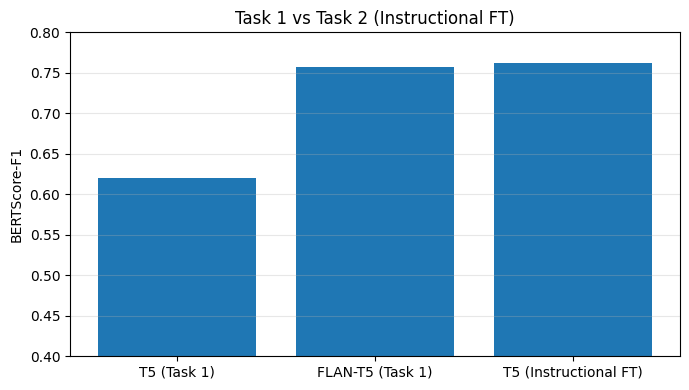

In [38]:
models = [r['model'] for r in comparison_results]
bert_scores = [r['bertscore_f1'] for r in comparison_results]

plt.figure(figsize=(7,4))
plt.bar(models, bert_scores)
plt.ylabel('BERTScore-F1')
plt.title('Task 1 vs Task 2 (Instructional FT)')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0.4, 0.8)
plt.tight_layout()
plt.show()

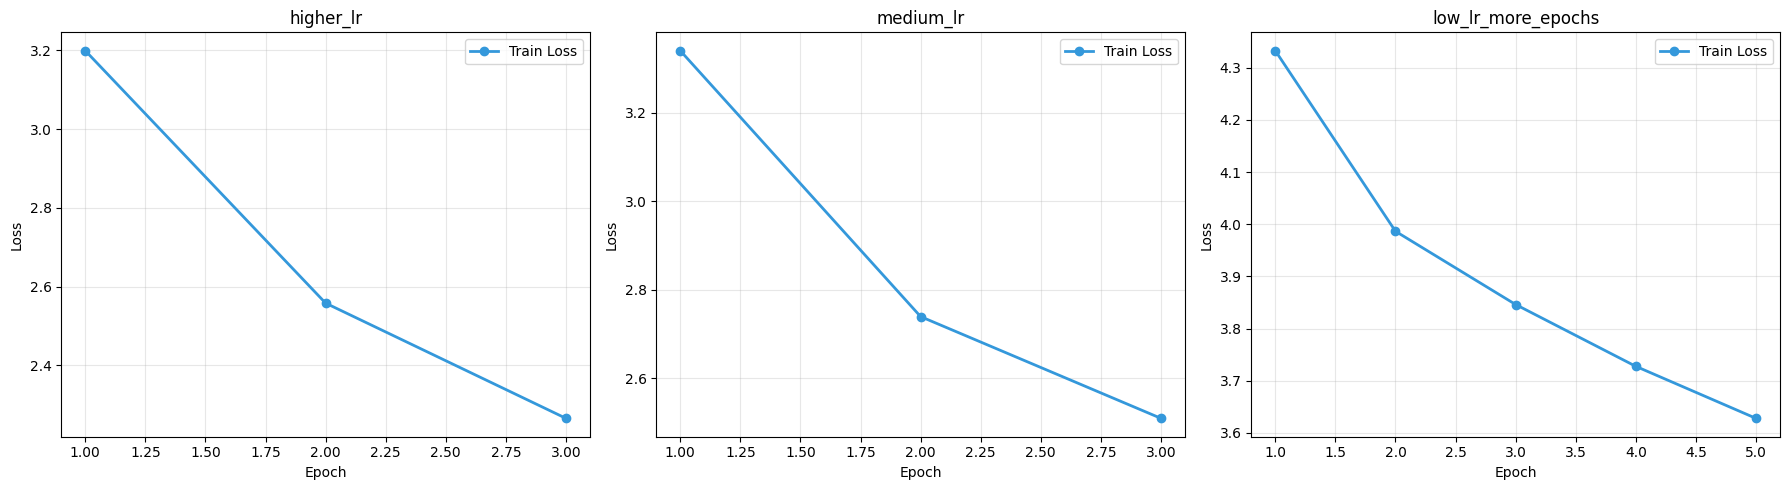

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, result in enumerate(results_t5_instruction):
    history = result['history']
    cfg_name = result['config']['name']
    epochs = range(1, len(history['train_loss']) + 1)

    axes[i].plot(epochs, history['train_loss'], marker='o', label='Train Loss', linewidth=2, color='#3498db')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Loss')
    axes[i].set_title(f'{cfg_name}')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()